In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from tqdm import tqdm

In [2]:
# device = 'cuda:0'
device = 'cpu'

# Low Rank Autoencoder

### Blocked autoencoder

In [3]:
class EncoderDecoder(nn.Module):
    def __init__(self, in_features, out_features, nonlinearity):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features   
        self.nonlinearity = nonlinearity
        
        self.encoder_decoder = nn.Sequential(nn.Linear(in_features, out_features),
                                             nonlinearity,
                                            )
    
    def forward(self, x):
        return self.encoder_decoder(x)

In [65]:
# DIFFERENT SAMPLING FUNCTIONS

def vector_sampling(normalized_factors, grid):
    encoded = normalized_factors @ grid
    return encoded

def softmax_sampling(normalized_factors, grid, temperature=0.01):
    B, out_features, n_bins = normalized_factors.shape
    cumsum_factors = torch.cumsum(normalized_factors, dim=-1)          # cumsum over bins
    y = torch.rand(B, out_features,1).to(device)                       # uniform random 
    abs_factors = torch.abs(cumsum_factors - y)                        # finding closest x via argmax
    final_factors = torch.softmax(-abs_factors/temperature, dim=-1)
    encoded = final_factors @ grid
    return encoded

def gumbell_sampling(normalized_factors, grid, temperature=0.01):
    eps = 1e-20
    logit_factors = torch.log(normalized_factors+eps) 
    y_unit = torch.rand(logit_factors.shape).to(device)
    y_logs = -torch.log(-torch.log(y_unit + eps) + eps)
    final_factors = torch.softmax((logit_factors + y_logs)/temperature, dim=-1)
    encoded = final_factors @ grid
    return encoded

def gumbell_torch_sampling(logit_factors, grid, temperature=0.5):
    final_factors = nn.functional.gumbel_softmax(logit_factors, tau=temperature, hard=False)
    encoded = final_factors @ grid
    return encoded

# SHIFTED MASKING FUNCTION - didn't prove to be of much help
def masking(normalized_factors, mask_size):
    B, out_features, n_bins = normalized_factors.shape
    assert n_bins % mask_size == 0 , f'n_bins={n_bins} must be divisible by mask_size={mask_size}'
    eps = 1e-9
    mask = torch.ones(B, out_features, n_bins).to(device)
    mask[::,::,0:mask_size] = 0
    mask = torch.roll(mask, torch.randint(low=0,high=n_bins-mask_size+1, size=(1,)).item(), dims=-1)
    dropped_factors = mask*normalized_factors + eps
    return dropped_factors

In [66]:
# Low Rank Pants class
class LowRankPants(nn.Module):
    def __init__(self, inter_features, out_features, n_bins, dropout, sampling, temperature):
        super().__init__()
        self.inter_features = inter_features
        self.out_features = out_features
        self.n_bins = n_bins
        self.dropout = dropout
        # sampling
        self.sampling = sampling
        self.temperature = temperature
        
        assert_message = 'Select: vector, softmax, gumbell, gumbell_torch'
        assert sampling in {'vector', 'softmax', 'gumbell', 'gumbell_torch'}, assert_message
        
        # coeff for logarithms
        self.eps = 1e-9/(n_bins*out_features)
        
        # coord grid
        grid = (torch.arange(1,n_bins+1)).to(device)
        self.grid = grid /n_bins
        
        # mapping to final probabilities (штаны)
        self.layers = nn.ModuleList([nn.Sequential(
                                                   nn.Linear(inter_features, n_bins),
                                                  )
                                                   for i in range(out_features)]
                                   )

        # dropout for randromized sampling
        self.dropout = nn.Dropout(dropout)
        
    # even faster forward - inner products with the range vec
    def forward(self,x):
        B = x.shape[0]

        # getting additional linear layer
        factors_list = []
        for layer in self.layers:
            factors_list.append(layer(x)) # (B, n_bins)
        # stack  them up
        factors = torch.stack(factors_list, dim=-1)
        factors_reshaped = factors.view(B, self.out_features, self.n_bins) # size = (B, out_features, n_bins)
        factors_probability = factors_reshaped
#         factors_probability = factors_reshaped/(torch.sum(factors_reshaped, dim=-1, keepdim=True))
        
        # randomized selection + added eps
#         dropped_factors = self.dropout(factors_probability) + self.eps
        
        # normalization
#         normalized_drop_factors = dropped_factors/(torch.sum(dropped_factors, dim=-1, keepdim=True))
        
        normalized_drop_factors = factors_probability
        # choosing the sampling
        if self.sampling == 'vector':
            encoded =  vector_sampling(normalized_drop_factors, self.grid)
        elif self.sampling == 'softmax':
            encoded = softmax_sampling(normalized_drop_factors, self.grid, self.temperature)
        elif self.sampling == 'gumbell':
            encoded = gumbell_sampling(normalized_drop_factors, self.grid, self.temperature)
        elif self.sampling == 'gumbell_torch':
            encoded = gumbell_torch_sampling(normalized_drop_factors, self.grid, self.temperature)
        
        return encoded, factors_probability

In [67]:
class LowRankAutoencoder(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins,
                 dropout, nonlinearity,
                 sampling, temperature):
        super().__init__() 
        # network feature sizes
        self.in_features = in_features
        self.inter_features = inter_features
        self.out_features = out_features
        self.n_bins = n_bins
        # network params
        self.nonlinearity = nonlinearity
        self.dropout = dropout
        # sampling params
        self.sampling = sampling
        self.temperature = temperature
        
        # encoder
        self.encoder = EncoderDecoder(in_features, inter_features, nonlinearity)
        
        # low rank probabilites
        self.low_rank_pants = LowRankPants(inter_features, out_features, n_bins, dropout, sampling, temperature)
        
        # intermediate_decoder
        self.intermediate_decoder = EncoderDecoder(out_features, inter_features, nonlinearity)
        
        # final decoder
        self.decoder = EncoderDecoder(inter_features, in_features, nonlinearity)
        
    def forward(self, x):
        encoded_inter_dim = self.encoder(x)
        encoded_out_dim, factors_probability = self.low_rank_pants(encoded_inter_dim)
        decoded_inter_dim = self.intermediate_decoder(encoded_out_dim)
        decoded = self.decoder(decoded_inter_dim)
        return decoded

In [70]:
LRA = LowRankAutoencoder(in_features=10, inter_features=20, out_features=2, n_bins=20,
                         dropout=0.0, nonlinearity=nn.ELU(),
                         sampling='gumbell_torch', temperature=0.1).to(device)

ttt = torch.rand(16, 10).to(device)
print(LRA(ttt).shape)
print(torch.sum(torch.isnan(LRA(ttt))))

torch.Size([16, 10])
tensor(0)


# Convolutional autoencoder
## Up and Down Blocks

In [71]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, nonlinearity=nn.ELU()):
        super().__init__()
        self.conv = nn.Conv2d(in_features, out_features,
                              kernel_size=4, stride=2, padding=1, dilation=1)
        self.nonlinearity = nonlinearity
        
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.nonlinearity(x1)
        return x2

In [72]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, scale_factor=2, nonlinearity=nn.ELU()):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_features, out_features,
                                           kernel_size=4, output_padding=0, padding=1, stride=2)
        self.nonlinearity = nonlinearity
        
    def forward(self, x):
        x1 = self.upsample(x)
        x2 = self.nonlinearity(x1)
        return x2

In [73]:
db = DownsampleBlock(in_features=8, out_features=8)
ttt = torch.rand(16,8,32,32)
db(db(db(ttt))).shape

torch.Size([16, 8, 4, 4])

In [74]:
ub = UpsampleBlock(in_features=8, out_features=8,)

ub(ub(ub(db(db(db(ttt)))))).shape

torch.Size([16, 8, 32, 32])

In [75]:
class ConvLRAE(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins,
                 dropout, nonlinearity,
                 sampling='vector', temperature=0.1,
                img_size=(32,32)):
        super().__init__()
        
        self.in_features = in_features   # input features after convolutions and flattening
        self.out_features = out_features # encoded dimension
        self.n_bins = n_bins
        # for flattening
        self.img_size = img_size
        self.flat_size = img_size[0]//8
        # network params
        self.nonlinearity = nonlinearity
        self.dropout = dropout
        # sampling params
        self.sampling = sampling
        self.temperature = temperature

        
        self.down = nn.Sequential(nn.Dropout(0.2),
                                  DownsampleBlock(in_features=1, out_features=32, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=32, out_features=64, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=64, out_features=128, nonlinearity=nonlinearity),
                                  )
        
        self.low_rank = LowRankAutoencoder(in_features, inter_features, out_features, n_bins,
                                           dropout, nonlinearity,
                                           sampling, temperature)
        
        self.up = nn.Sequential(
                                UpsampleBlock(in_features=128, out_features=64, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=64, out_features=32, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=32, out_features=1,  nonlinearity=nn.Tanh()),
                                )
        
    def forward(self, x):
        # downsample
        x_down = self.down(x)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        
        # passing theough low rank
        decoded = self.low_rank(x_flat)

        # upsample
        x_2d = decoded.view(B, C, H, W)
        x_out = self.up(x_2d)

        return x_out
            
            

In [76]:
mdl = ConvLRAE(in_features=128*4*4, inter_features=256, out_features=4, n_bins=20,
                sampling='gumbell_torch', dropout=0.1, nonlinearity=nn.ReLU()
              ).to(device)

ttt = torch.randn(10, 1, 32, 32).to(device)

mdl(ttt).shape

torch.Size([10, 1, 32, 32])

### Dataset class

In [77]:
from torch.utils.data import Dataset, DataLoader

class MNIST_DS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.X = self.X/torch.max(self.X) # normalizing to 1.
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        return x,y

### Torchvision dataset

In [78]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

train_ds_mnist = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))
test_ds_mnist = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))

# dataset and dataloader
TRAIN_SIZE = 60000
TEST_SIZE = 5000
BATCH_SIZE = 64
dl = DataLoader(train_ds_mnist, batch_size=BATCH_SIZE,     num_workers=1)
dl_test = DataLoader(test_ds_mnist, batch_size=BATCH_SIZE, num_workers=1)

#full dataset train
FULL_TRAIN_SIZE = 10000
dl_full = DataLoader(train_ds_mnist, batch_size=FULL_TRAIN_SIZE)
for x, y in dl_full:
    X_full_train = x
    targets = y
    break

#full dataset train
FULL_TEST_SIZE = 10000
dl_full = DataLoader(test_ds_mnist, batch_size=FULL_TEST_SIZE)
for x, y in dl_full:
    X_full_test = x
    targets_test = y
    break

print(X_full_train.shape)
print(torch.max(X_full_train))
print(targets.unique(return_counts=True))

torch.Size([10000, 1, 32, 32])
tensor(1.)
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([1001, 1127,  991, 1032,  980,  863, 1014, 1070,  944,  978]))


In [79]:
torch.manual_seed(0)

In [94]:
torch.cuda.empty_cache()

model = ConvLRAE(in_features=128*4*4, inter_features=512, out_features=8, n_bins=20,
                dropout=0.0, nonlinearity=nn.ELU(),
                sampling='gumbell_torch', temperature=0.5,
                ).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [95]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 100
model.train()
optimizer.zero_grad()

loss_list_train = []
loss_train_cum = 0

loss_list_test = []
loss_test_cum = 0
i = 0

for epoch in tqdm(range(EPOCHS)):
    # Forward pass: Compute predicted y by passing x to the model
    
    for x_batch, y_batch in dl:

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # model forward
        # 2d downsampling
        x_down = model.down(x_batch)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        encoded_inter_dim =                    model.low_rank.encoder(x_flat)
        encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(encoded_inter_dim)
        decoded_inter_dim =                    model.low_rank.intermediate_decoder(encoded_out_dim)
        # # skipconnection
        # if np.random.rand(1)[0]>0.9:
        #     decoded_1d = model.low_rank.decoder(decoded_inter_dim)
        # else:
        #     decoded_1d = model.low_rank.decoder(encoded_inter_dim)

        decoded_1d = model.low_rank.decoder(decoded_inter_dim)
        # 2d upsampling
        decoded_2d_small = decoded_1d.view(B, C, H, W)
        decoded_2d = model.up(decoded_2d_small)

#         loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        factors_probability = nn.Softmax(dim=-1)(factors_probability)
        loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        loss = criterion(decoded_2d.view(-1), x_batch.view(-1)) + 1e-2*torch.mean(torch.exp(loss_entropy))
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # accumulate loss
        loss_train_cum += loss.item()
        
        # validation and saving
        i += 1
        if i % 100 == 0:
            loss_list_train.append(loss_train_cum/100)
            loss_train_cum = 0
            with torch.no_grad():
                model.eval() # put to eval
                for x_batch, y_batch in dl_test:
                    # model forward
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    x_decoded = model(x_batch)

                    loss_test = criterion(x_decoded.view(-1), x_batch.view(-1))
                    loss_test_cum += loss_test.item()
                model.train() # put back to train
            # save to list
            loss_list_test.append(loss_test_cum/len(dl_test))
            loss_test_cum = 0
            
    #     break
    # break

 25%|███████████████████                                                         | 25/100 [1:45:40<5:17:02, 253.63s/it]


KeyboardInterrupt: 

In [96]:
torch.sum(torch.isnan(x_decoded))

tensor(0)

In [97]:
print(torch.mean(torch.exp(loss_entropy)))
# print(criterion(decoded_2d.view(-1), x_batch.view(-1)))

tensor(0.2883, grad_fn=<MeanBackward0>)


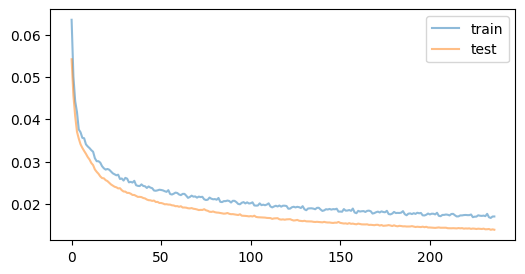

In [98]:
plt.figure(figsize=(6,3))
plt.plot(loss_list_train, alpha=0.5, label='train')
plt.plot(loss_list_test, alpha=0.5, label='test')
# plt.yscale('log')
plt.legend()
plt.savefig('MNIST_Gumbell_torch.png')
plt.show()

### Reconstruction and distribution graphs

In [99]:
def inf_by_layers(model, x_batch):
    # forward pass with intermediate layers
    x_down = model.down(x_batch)
    B, C, H, W = x_down.shape
    x_flat = x_down.view(B,C*H*W)
    encoded_inter_dim =                    model.low_rank.encoder(x_flat)
    encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(encoded_inter_dim)
    decoded_inter_dim =                    model.low_rank.intermediate_decoder(encoded_out_dim)
    decoded_1d =                           model.low_rank.decoder(decoded_inter_dim)
    decoded_2d_small = decoded_1d.view(B, C, H, W)
    decoded_2d = model.up(decoded_2d_small)

    return decoded_2d, encoded_out_dim, factors_probability

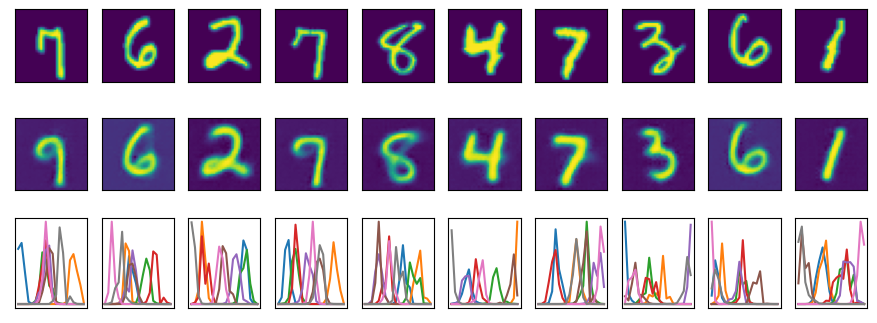

In [101]:
fig, axs = plt.subplots(3,10, figsize=(11,4))

for i in range(0,10):
    INDX=i+80
    #true
    
    #pred
    with torch.no_grad():
        model.eval()
        x_batch = X_full_test[INDX].unsqueeze(0).to(device)
        
        # plotting original images
        axs[0,i].imshow(x_batch[0,0].cpu().detach().numpy()) # mnist

        # forward pass with intermediate layers
        decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
        
    axs[1,i].imshow(decoded_2d.cpu().detach().numpy()[0,0]) # mnist

    
    # 1d probabilities
    for j in range(factors_probability.shape[1]):
        axs[2,i].plot(nn.Softmax(dim=-1)(factors_probability)[0,j,::].cpu().detach().numpy())
#         axs[2,i].set_ylim(-0.1,1.1)
        
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])

# plt.savefig('MNIST_softmax_plus_Reconstruction.png')
plt.show()

In [102]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, X_full_test.to(device))
    

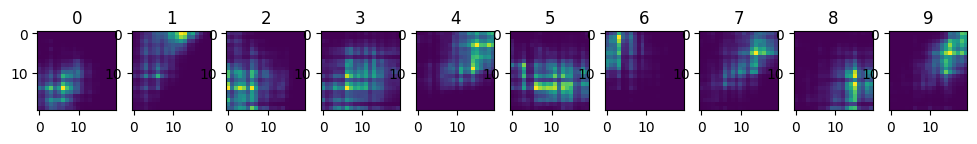

In [103]:
# plot
fig, axs = plt.subplots(1,10, figsize=(12,2))
fbs = nn.Softmax(dim=-1)(factors_probability)
for i in range(0,10):
    f1, f2 = fbs[::,0,::], fbs[::,1,::]
    probs = np.zeros((f1.shape[-1],f1.shape[-1]))
    # selecting the encoded distibution vectors
    f1_cls, f2_cls = f1[targets_test == i], f2[targets_test == i]
    for f1_vec, f2_vec in zip(f1_cls, f2_cls):
        probs += np.outer(f1_vec.cpu().detach().numpy(), f2_vec.cpu().detach().numpy())
            
    axs[i].imshow(probs)
#     axs[i].set_xticks(model.range.detach().numpy()/20)
#     axs[i].set_yticks(model.range.detach().numpy()/20)
    
    axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_2d_distribution.png')

plt.show()

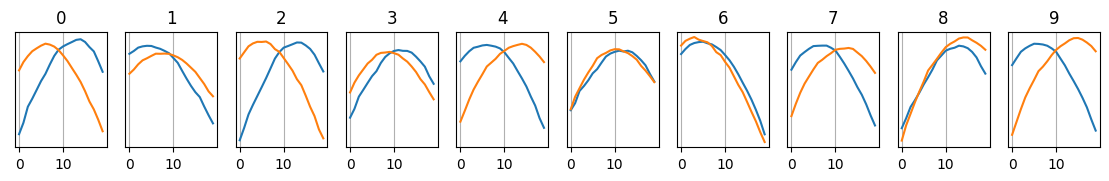

In [104]:
# plot
fig, axs = plt.subplots(1,10, figsize=(14,1.5), sharey=True)
for i in range(0,10):
    axs[i].plot(np.mean(factors_probability.cpu().detach().numpy()[targets_test == i], axis=0)[0])
    axs[i].plot(np.mean(factors_probability.cpu().detach().numpy()[targets_test == i], axis=0)[1])
    
    axs[i].grid(True)
    
    axs[i].set_yticks([])
#     axs[i].set_ylim(0,0.5)

    axs[i].set_title(f'{i}')
plt.show()

# Visualization

In [110]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d_train, encoded_out_dim_train, factors_probability_train = inf_by_layers(model, X_full_train.to(device))
    decoded_2d_test, encoded_out_dim_test, factors_probability_test = inf_by_layers(model, X_full_test.to(device))  


### PCA

In [111]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

enc_pca_train = pca.fit_transform(encoded_out_dim_train.cpu().detach().numpy())
enc_pca_test = pca.fit_transform(encoded_out_dim_test.cpu().detach().numpy())


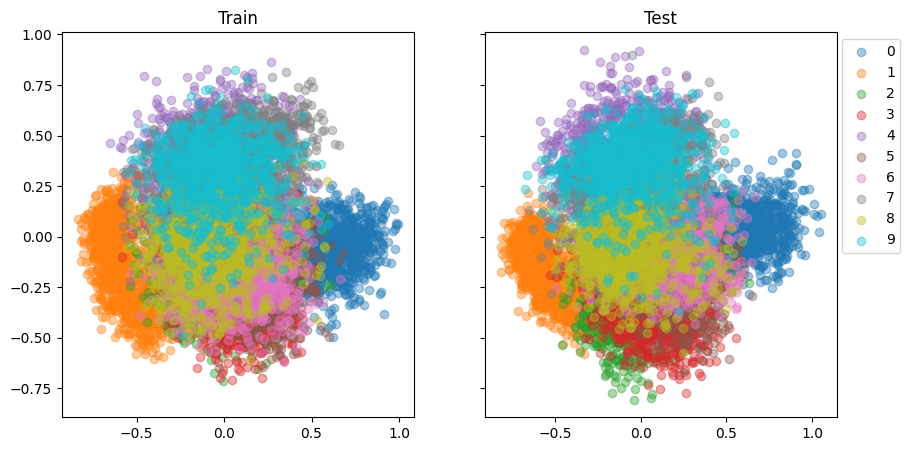

In [112]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    X_pca_train = enc_pca_train[targets == cls]
    axs[0].scatter(X_pca_train[::,0], X_pca_train[::,1], label=cls, alpha=0.4)
    
    X_pca_test = enc_pca_test[targets_test == cls]
    axs[1].scatter(X_pca_test[::,0], X_pca_test[::,1], label=cls, alpha=0.4)

axs[0].set_title('PCA Train')
axs[1].set_title('PCA Test')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.savefig('MNIST_Gumbell_PCA.png')
plt.show()

### T-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

enc_tsne_train = tsne.fit_transform(encoded_out_dim_train.cpu().detach().numpy())
enc_tsne_test = tsne.fit_transform(encoded_out_dim_test.cpu().detach().numpy())


In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    X_tsne_train = enc_tsne_train[targets == cls]
    axs[0].scatter(X_tsne_train[::,0], X_tsne_train[::,1], label=cls, alpha=0.4)
    
    X_tsne_test = enc_tsne_test[targets_test == cls]
    axs[1].scatter(X_tsne_test[::,0], X_tsne_test[::,1], label=cls, alpha=0.4)

axs[0].set_title('TSNE Train')
axs[1].set_title('TSNE Test')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.savefig('MNIST_Gumbell_PCA.png')
plt.show()

# Generation

In [ ]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d_train, encoded_out_dim_train, factors_probability_train = inf_by_layers(model, X_full_train.to(device))
    decoded_2d_test, encoded_out_dim_test, factors_probability_test = inf_by_layers(model, X_full_test.to(device))  


### Multivariate Gaussian Generation

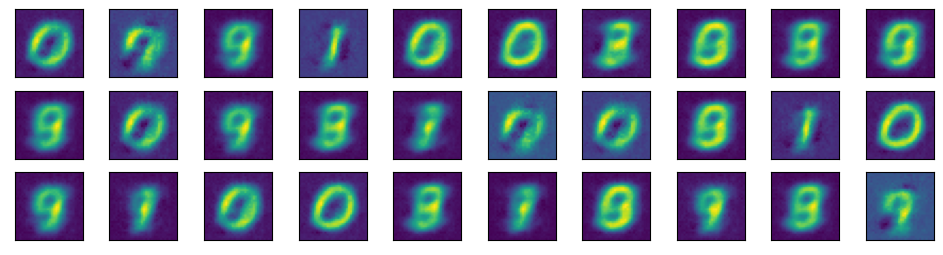

In [36]:
# plot
EMB_SIZE = 8

mean_vec = torch.mean(decoded_2d_train, dim=0)
std_vec = torch.std(decoded_2d_train, dim=0)

fig, axs = plt.subplots(3,10, figsize=(12,3))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in range(3):
            rand = torch.randn(EMB_SIZE).to(device)*std_vec + mean_vec
            x_down = model.down(x_batch)
            B, C, H, W = (1,128,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])



    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
#     axs[i].set_title(f'{i}')

plt.savefig('MNIST_Multivariate_Gaussian_Generation.png')
plt.show()

### K-means Generation

In [ ]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(3,10, figsize=(12,3))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in range(3):
            rand = torch.randn(EMB_SIZE).to(device)*std_vec + mean_vec
            x_down = model.down(x_batch)
            B, C, H, W = (1,128,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])



    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
#     axs[i].set_title(f'{i}')

plt.savefig('MNIST_K_means_Generation.png')
plt.show()

### Numbers transition

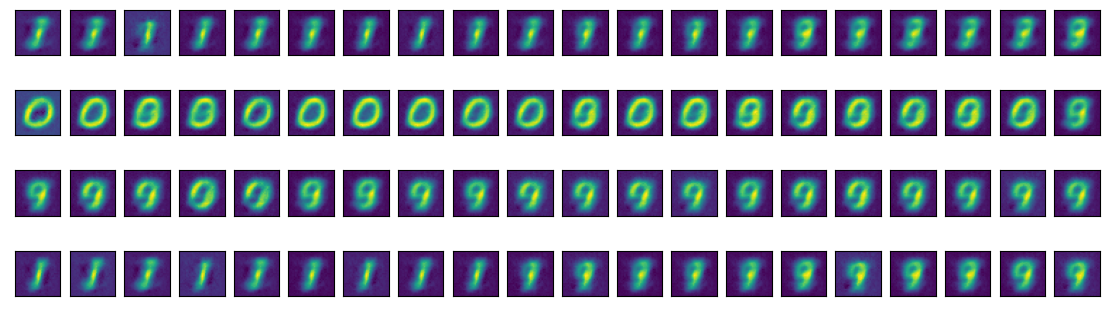

In [37]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(4,20, figsize=(14,4))
for i in range(0,20):
    with torch.no_grad():
        model.eval()
            
        for j in range(4):
            # encode two numbers
            # NUMBER 1
            IDX_1 = j+2
            x_down1 = model.down(X_full_test[IDX_1].unsqueeze(0).to(device))
            B, C, H, W = x_down1.shape
            x_flat1 = x_down1.view(B,C*H*W)
            encoded_inter_dim1 =                    model.low_rank.encoder(x_flat1)
            encoded_out_dim1, factors_probability1 = model.low_rank.low_rank_pants(encoded_inter_dim1)

            # NUMBER 2
            IDX_2 = j+20
            x_down2 = model.down(X_full_test[IDX_2].unsqueeze(0).to(device))
            B, C, H, W = x_down2.shape
            x_flat2 = x_down2.view(B,C*H*W)
            encoded_inter_dim2 =                    model.low_rank.encoder(x_flat2)
            encoded_out_dim2, factors_probability2 = model.low_rank.low_rank_pants(encoded_inter_dim2)

            # decode and plot
            new_encoded = (1-i/axs.shape[-1])*encoded_out_dim1 + (i/axs.shape[-1])*encoded_out_dim2
            decoded_inter_dim =  model.low_rank.intermediate_decoder(new_encoded)
            decoded_1d = model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
plt.show()

In [38]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d1, encoded_out_dim1, factors_probability1 = inf_by_layers(model, X_full_train.to(device))  
    decoded_2d2, encoded_out_dim2, factors_probability2 = inf_by_layers(model, X_full_test.to(device))

### K-means generation

In [307]:
# getting probability tensor from single rank-1 factors
def get_prob_tensor(factors):
    f_init = torch.tensor(1.).to(device)
    for factor in factors:
        f_init = torch.tensordot(f_init, factor, dims=0)
    return f_init

N_SUM = 1000

prob_tensor_train = get_prob_tensor(factors_probability1[0])
for i in tqdm(range(1,len(factors_probability1))[0:N_SUM]):
    prob_tensor_train += get_prob_tensor(factors_probability1[i])

prob_tensor_train = prob_tensor_train/N_SUM

100%|██████████| 9999/9999 [00:28<00:00, 356.85it/s]


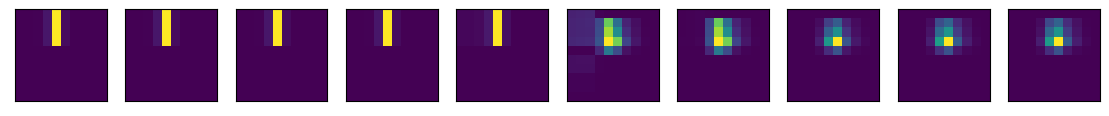

In [312]:
fig, axs = plt.subplots(1,10, figsize=(14,2))
for i in range(10):
    axs[i].imshow(prob_tensor_train[i][0][0][0][0][0].cpu().detach().numpy())
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()


In [313]:
def get_sample_vec(prob_tensor, N_iter=100):
    feature_size = len(prob_tensor.shape)
    n_bins = prob_tensor.shape[0]
    
    vector = torch.zeros(feature_size).to(device)
    probs_sum = 0
    for i in range(N_iter):
        xyzt = torch.randint(low=0,high=n_bins, size=(feature_size,)).to(device)
        prob_coef = prob_tensor_train[tuple(xyzt)]
        vector += (xyzt+1)*prob_coef # +1 because we made range from 1 to n_bins + 1
        probs_sum += prob_coef
    # normalizing
    vector = vector/probs_sum#*torch.numel(prob_tensor)/N_iter
    return vector/n_bins, probs_sum/N_iter
    

In [314]:
xyzt = torch.randint(low=0,high=10, size=(8,)).to(device)
xyzt+1

tensor([ 1,  1, 10,  3,  7,  8,  3,  6], device='cuda:0')

In [315]:
torch.numel(prob_tensor_train)

100000000

In [316]:
torch.mean(prob_tensor_train)

tensor(1.0000e-08, device='cuda:0')

In [317]:
get_sample_vec(prob_tensor_train, N_iter=10)

(tensor([0.7596, 0.2701, 0.6387, 0.3733, 0.4072, 0.1960, 0.5347, 0.6128],
        device='cuda:0'),
 tensor(4.7386e-10, device='cuda:0'))

100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


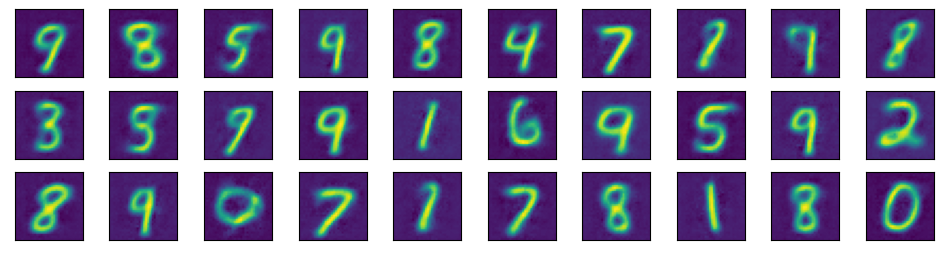

In [318]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(3,10, figsize=(12,3))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in tqdm(range(3)):
            prob = 0
            while prob < torch.mean(prob_tensor_train) + 2*torch.std(prob_tensor_train):
                rand, prob = get_sample_vec(prob_tensor_train, N_iter=10)
            x_down = model.down(x_batch)
            B, C, H, W = (1,128,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])



    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
#     axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_Generation.png')
plt.show()

In [154]:
rand

tensor([3.0195, 3.8174, 2.6379, 2.8604, 1.1320, 1.3091, 2.6554, 1.1157],
       device='cuda:0')